# 1. Setup e Imports

In [1]:
# - Local (VS Code): instalar deps con `pip install -r requirements.txt` y correr directo.
# - Colab: esta celda instala solo lo necesario, sin desinstalar nada.

import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip -q install --upgrade --force-reinstall "numpy==1.26.4"
    %pip -q install "pandas>=1.5,<2.3" "matplotlib>=3.7,<3.9" "seaborn>=0.12" "scipy>=1.10,<1.14" "fitter==1.7.1"

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fitter import Fitter
import random
from datetime import datetime, timedelta

# Estilo
sns.set(style="whitegrid")
np.random.seed(42)
random.seed(42)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

# (Opcional) mostrar versiones en Colab
if IN_COLAB:
    import importlib
    for m in ("numpy","pandas","matplotlib","seaborn","scipy","fitter"):
        mod = importlib.import_module(m)
        print(f"{m:>10}: {getattr(mod,'__version__','?')}")

# 2. Ingesta Dataset externo

In [ ]:
import os, sys
from pathlib import Path
import numpy as np, pandas as pd
from scipy import stats

# Detectar si estamos en Colab
IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    DATA_DIR = Path("/content/inputs")            # Colab
else:
    DATA_DIR = Path.cwd() / "inputs"              # Local: carpeta 'inputs' junto al notebook

USE_DATASET   = True
DATA_SOURCE   = "params"  # "params" (fdp_params.csv) | "samples" (ts/llin_samples.csv)

FDP_PARAMS_CSV    = DATA_DIR / "fdp_params.csv"
TS_SAMPLES_CSV    = DATA_DIR / "ts_samples.csv"
LLIN_SAMPLES_CSV  = DATA_DIR / "llin_samples.csv"

DATA_DIR.mkdir(parents=True, exist_ok=True)

def _samplers_from_params(csv_path: Path):
    df = pd.read_csv(csv_path)
    samplers, time_unit = {}, None
    for _, r in df.iterrows():
        var = str(r["variable"]).strip().upper()
        dist_name = str(r["dist"]).strip()
        d = getattr(stats, dist_name)

        # Lognormal: preferimos mu/sigma (log). Si no, shape/loc/scale.
        if dist_name == "lognorm" and pd.notna(r.get("mu")) and pd.notna(r.get("sigma")):
            s = float(r["sigma"])
            loc = float(r.get("loc", 0.0))
            scale = float(r.get("scale", np.exp(float(r["mu"]))))
            args = (s, loc, scale)
        else:
            shapes = []
            for nm in ("shape1", "shape2"):
                if nm in r and pd.notna(r[nm]): shapes.append(float(r[nm]))
            loc = float(r.get("loc", 0.0))
            scale = float(r.get("scale", 1.0))
            args = tuple(shapes + [loc, scale])

        def _mk(_d, _args):
            def _draw(n=1):
                x = _d.rvs(*_args, size=n)
                return float(np.maximum(0.0, x)) if n == 1 else np.maximum(0.0, x)
            return _draw

        samplers[var] = _mk(d, args)
        if "time_unit" in r and isinstance(r["time_unit"], str):
            time_unit = r["time_unit"]
    return samplers, time_unit

def _sampler_from_samples(csv_path: Path, col: str):
    s = pd.read_csv(csv_path)[col].astype(float)
    s = s[np.isfinite(s) & (s > 0)].sort_values().to_numpy()
    if len(s) < 10:
        raise ValueError(f"Pocas muestras en {csv_path}")
    probs = (np.arange(len(s)) + 0.5) / len(s)
    def _draw_one():
        u = np.random.rand()
        return float(np.interp(u, probs, s))
    return _draw_one

# Construir samplers según DATA_SOURCE
if USE_DATASET:
    if DATA_SOURCE == "params":
        if not FDP_PARAMS_CSV.exists():
            raise FileNotFoundError(
                f"No encuentro {FDP_PARAMS_CSV}. "
                f"Creá la carpeta 'inputs' junto al notebook y poné 'fdp_params.csv' adentro."
            )
        SAMPLERS, DATA_TIME_UNIT = _samplers_from_params(FDP_PARAMS_CSV)
        TS_sampler   = SAMPLERS["TS"]
        LLIN_sampler = SAMPLERS["LLIN"]
    else:
        if not (TS_SAMPLES_CSV.exists() and LLIN_SAMPLES_CSV.exists()):
            raise FileNotFoundError("Faltan ts_samples.csv y/o llin_samples.csv dentro de ./inputs/")
        TS_sampler   = _sampler_from_samples(TS_SAMPLES_CSV, "ts")
        LLIN_sampler = _sampler_from_samples(LLIN_SAMPLES_CSV, "llin")
        DATA_TIME_UNIT = "días"  # ajustá si tu dataset guarda otra unidad

    # Aviso si la unidad del dataset difiere de la de la simulación (si existe)
    sim_unit = globals().get("TIME_UNIT", None)  # <- no rompe Pylance
    if USE_DATASET and DATA_TIME_UNIT and sim_unit and DATA_TIME_UNIT != sim_unit:
        print(f"⚠️ Dataset usa '{DATA_TIME_UNIT}' y la simulación usa '{sim_unit}'. Verificá unidades.")

# 3. Generación de Datos Simulados

In [ ]:
# --- Parámetros de simulación ---
TIME_UNIT = "días"
N_EVENTOS = 1000
GAS = 50
VALOR_TOKEN_MEDIA = 1000
VALOR_TOKEN_SD = 200

# Probabilidades de eventos secundarios
P_BURN = 0.05
P_UPDATE = 0.1

# --- Estado inicial ---
partes_de_prop = 1000                 # límite superior de tokens que se pueden emitir
tokens_vend = []                      # tokens disponibles (no vendidos y no burneados)
saldo_vend = 5000
eventos = []
tiempo = 0.0

# Métricas en vivo
CTS = 0                               # tokenizaciones (mint) realizadas
CTF = 0                               # compras fallidas (fondos/sin tokens)
tokens_emitidos = 0
tokens_burneados = 0
saldos_compradores = []

# --- Funciones auxiliares ---
def generar_TS():
    # Si hay dataset, usalo
    if 'USE_DATASET' in globals() and USE_DATASET:
        return max(0.0, TS_sampler())
    # Fallback (lo que ya tenías)
    return np.random.exponential(scale=5.0)

def generar_LLIN():
    if 'USE_DATASET' in globals() and USE_DATASET:
        return max(0.0, LLIN_sampler())
    return np.random.lognormal(mean=2.5, sigma=0.5)

def generar_saldo_comprador():
    return int(np.random.randint(500, 5000))


def generar_valor_token():
    return max(10, int(np.random.normal(VALOR_TOKEN_MEDIA, VALOR_TOKEN_SD)))

# --- Simulación principal ---
for i in range(N_EVENTOS):
    r = random.random()

    if r < 0.35:
        # TTS (tokenización solicitada) → TM (mint) si hay capacidad y saldo para gas
        tiempo += generar_TS()
        # ⚠️ Capacidad: limitar por tokens emitidos totales, no por len(tokens_vend)
        if (tokens_emitidos < partes_de_prop) and (saldo_vend >= GAS):
            CTS += 1
            saldo_vend -= GAS
            token_id = f"T{tokens_emitidos}"
            tokens_vend.append({"id": token_id, "precio": generar_valor_token()})
            tokens_emitidos += 1
            eventos.append([tiempo, "mint", token_id, saldo_vend, None])

    elif r < 0.7:
        # TLLI (llegada interesado) y TCI (compra)
        tiempo += generar_LLIN()
        kyc_interesado = random.choice([True, False])
        if kyc_interesado:
            saldo_comprador = generar_saldo_comprador()
            if tokens_vend:
                token = random.choice(tokens_vend)
                precio = token["precio"]
                if saldo_comprador >= precio:
                    # compra_exitosa
                    saldo_comprador -= precio
                    saldo_vend += precio
                    tokens_vend.remove(token)
                    saldos_compradores.append(saldo_comprador)
                    eventos.append([tiempo, "compra_exitosa", token["id"], saldo_vend, saldo_comprador])
                else:
                    # compra_fallida por fondos
                    CTF += 1
                    eventos.append([tiempo, "compra_fallida_fondos", token["id"], saldo_vend, saldo_comprador])
            else:
                # compra_fallida por falta de tokens
                CTF += 1
                eventos.append([tiempo, "compra_fallida_sin_tokens", None, saldo_vend, saldo_comprador])

    else:
        # Eventos secundarios: burn o actualización de precio
        tiempo += np.random.exponential(scale=3.0)
        if tokens_vend:
            token = random.choice(tokens_vend)
            if random.random() < P_BURN:
                tokens_vend.remove(token)
                tokens_burneados += 1
                eventos.append([tiempo, "burn_token", token["id"], saldo_vend, None])
            elif random.random() < P_UPDATE:
                nuevo_precio = generar_valor_token()
                token["precio"] = nuevo_precio
                eventos.append([tiempo, "actualizacion_precio", token["id"], saldo_vend, nuevo_precio])

# --- DataFrame de eventos ---
df_eventos = pd.DataFrame(
    eventos,
    columns=["tiempo", "evento", "token", "saldo_vendedor", "extra"]
).sort_values("tiempo", ignore_index=True)
df_eventos["tiempo"] = pd.to_numeric(df_eventos["tiempo"], errors="coerce")

# --- Invariantes / chequeos rápidos ---
assert saldo_vend >= 0, "Saldo del vendedor no puede ser negativo"
current_unsold = len(tokens_vend)
assert tokens_emitidos >= tokens_burneados + current_unsold, "Inconsistencia de supply (emitidos < burn + stock)"

# 4. Análisis Exploratorio de Datos

▶ Forma del dataset: (552, 5)
▶ Columnas: ['tiempo', 'evento', 'token', 'saldo_vendedor', 'extra']
▶ Tiempo simulado: min=15.62, max=7699.11 días

▶ Primeras filas:
   tiempo                    evento token  saldo_vendedor  extra
15.616953 compra_fallida_sin_tokens  None            5000 4272.0
21.293738                      mint    T0            4950    NaN
21.820401                      mint    T1            4900    NaN
22.591211                      mint    T2            4850    NaN
26.038629                      mint    T3            4800    NaN
26.042524                      mint    T4            4750    NaN
38.361131            compra_exitosa    T4            5773 2035.0
39.112304                      mint    T5            5723    NaN
49.893776                      mint    T6            5673    NaN
58.786759            compra_exitosa    T1            6270 1170.0

▶ Frecuencia de eventos:
evento
mint                         359
compra_exitosa               138
actualizacion_precio 

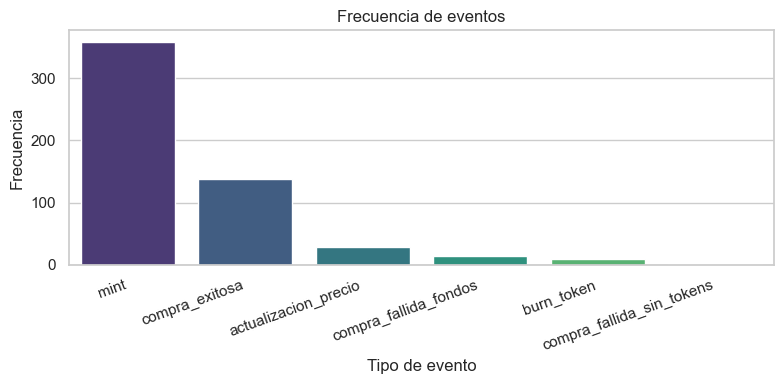

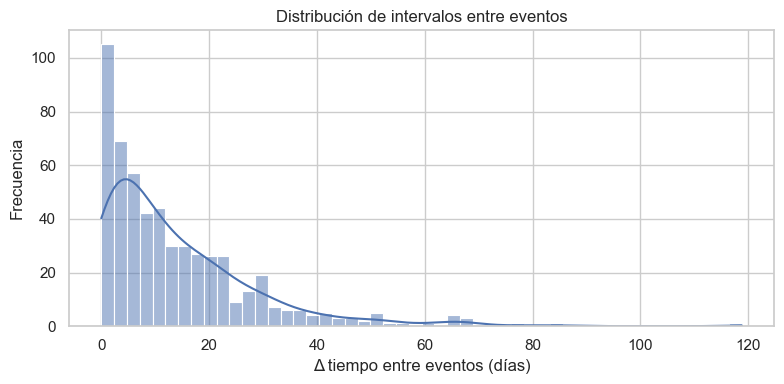

TS (Δ entre mints) — n=358 | media=21.45 días | mediana=13.01 días


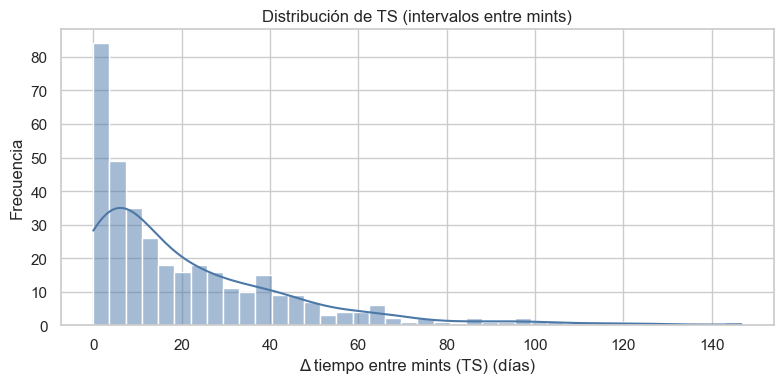

LLIN (Δ entre compras) — n=153 | media=49.85 días | mediana=38.96 días


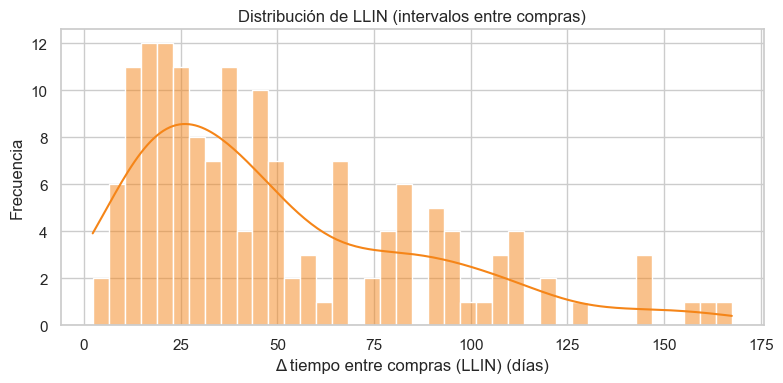

In [20]:
print("▶ Forma del dataset:", df_eventos.shape)
print("▶ Columnas:", list(df_eventos.columns))
print(f"▶ Tiempo simulado: min={df_eventos['tiempo'].min():.2f}, max={df_eventos['tiempo'].max():.2f} {TIME_UNIT}")

print("\n▶ Primeras filas:")
print(df_eventos.head(10).to_string(index=False))

print("\n▶ Frecuencia de eventos:")
evt_counts = df_eventos['evento'].value_counts()
print(evt_counts.to_string())

# --- Gráfico: Frecuencia por tipo de evento (seaborn con hue y sin leyenda) ---
df_evt = evt_counts.rename_axis('evento').reset_index(name='frecuencia')

plt.figure(figsize=(8,4))
sns.barplot(
    data=df_evt,
    x="evento", y="frecuencia",
    hue="evento", palette="viridis",
    dodge=False, legend=False
)
plt.xlabel("Tipo de evento")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de eventos")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# --- Intervalos entre eventos (Δ tiempo real) ---
intervalos = df_eventos['tiempo'].diff().dropna()

plt.figure(figsize=(8,4))
sns.histplot(intervalos, bins=50, kde=True)
plt.xlabel(f"Δ tiempo entre eventos ({TIME_UNIT})")
plt.ylabel("Frecuencia")
plt.title("Distribución de intervalos entre eventos")
plt.tight_layout()
plt.show()

# --- TS (Δ entre mints) y LLIN (Δ entre compras) ---
tiempos_token = (
    df_eventos[df_eventos['evento'].str.lower() == "mint"]['tiempo']
    .diff()
    .dropna()
)
tiempos_llin = (
    df_eventos[df_eventos['evento'].str.contains("compra", case=False, na=False)]['tiempo']
    .diff()
    .dropna()
)

# Resúmenes y gráficos con unidades
if len(tiempos_token):
    print(f"TS (Δ entre mints) — n={len(tiempos_token)} | media={tiempos_token.mean():.2f} {TIME_UNIT} | mediana={tiempos_token.median():.2f} {TIME_UNIT}")
    plt.figure(figsize=(8,4))
    sns.histplot(tiempos_token, bins=40, kde=True, color="#4C78A8")
    plt.xlabel(f"Δ tiempo entre mints (TS) ({TIME_UNIT})")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de TS (intervalos entre mints)")
    plt.tight_layout()
    plt.show()
else:
    print("TS: no hay suficientes mints para calcular intervalos.")

if len(tiempos_llin):
    print(f"LLIN (Δ entre compras) — n={len(tiempos_llin)} | media={tiempos_llin.mean():.2f} {TIME_UNIT} | mediana={tiempos_llin.median():.2f} {TIME_UNIT}")
    plt.figure(figsize=(8,4))
    sns.histplot(tiempos_llin, bins=40, kde=True, color="#F58518")
    plt.xlabel(f"Δ tiempo entre compras (LLIN) ({TIME_UNIT})")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de LLIN (intervalos entre compras)")
    plt.tight_layout()
    plt.show()
else:
    print("LLIN: no hay suficientes compras para calcular intervalos.")


# 5. Ajuste de FDPs (TS y LLIN)


Promedio intervalo entre tokenizaciones (TS): 21.45 días
Promedio intervalo entre llegadas de interesados (LLIN): 49.85 días

Mejores ajustes TS:
{'gamma': {'a': 0.7991253101061306, 'loc': 0.0026025621920666704, 'scale': 26.84279664531793}}

Mejores ajustes LLIN:
{'lognorm': {'s': 0.724994516080854, 'loc': -2.6139731817456946, 'scale': 40.941130981374435}}


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.002190,1144.240953,1153.332267,inf,0.066434,0.488601
gamma,0.002289,1132.392098,1141.483412,inf,0.056514,0.691190
expon,0.003151,1123.743230,1129.804106,inf,0.116184,0.029552
norm,0.003651,1166.722904,1172.783780,inf,0.151738,0.001533


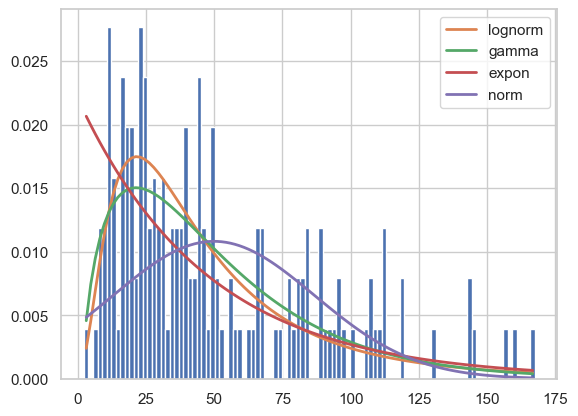

In [21]:
tiempos_token = df_eventos[df_eventos['evento']=="mint"]['tiempo'].diff().dropna()
tiempos_llin = df_eventos[df_eventos['evento'].str.contains("compra")]['tiempo'].diff().dropna()

print(f"\nPromedio intervalo entre tokenizaciones (TS): {tiempos_token.mean():.2f} {TIME_UNIT}")
print(f"Promedio intervalo entre llegadas de interesados (LLIN): {tiempos_llin.mean():.2f} {TIME_UNIT}")

# Ajuste TS
f_ts = Fitter(tiempos_token, distributions=['expon','gamma','lognorm','norm'])
f_ts.fit()
print("\nMejores ajustes TS:")
print(f_ts.get_best(method='sumsquare_error'))
f_ts.summary(5)

# Ajuste LLIN
f_llin = Fitter(tiempos_llin, distributions=['expon','gamma','lognorm','norm'])
f_llin.fit()
print("\nMejores ajustes LLIN:")
print(f_llin.get_best(method='sumsquare_error'))
f_llin.summary(5)

# 6. Verificación


Verificación TS (entre mints): muestreamos de gamma y re-ajustamos
Top (sumsquare_error): {'gamma': {'a': 0.8328438434291707, 'loc': 0.002808985626774921, 'scale': 25.25831094640327}}


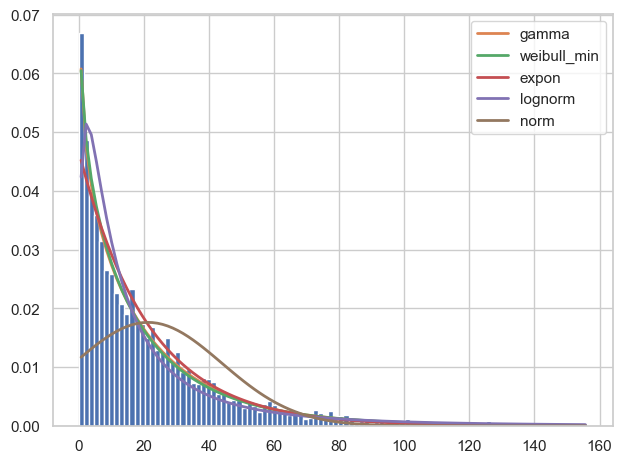


Verificación LLIN (entre compras): muestreamos de lognorm y re-ajustamos
Top (sumsquare_error): {'lognorm': {'s': 0.7509771752127868, 'loc': -2.108988464371272, 'scale': 40.60378640393388}}


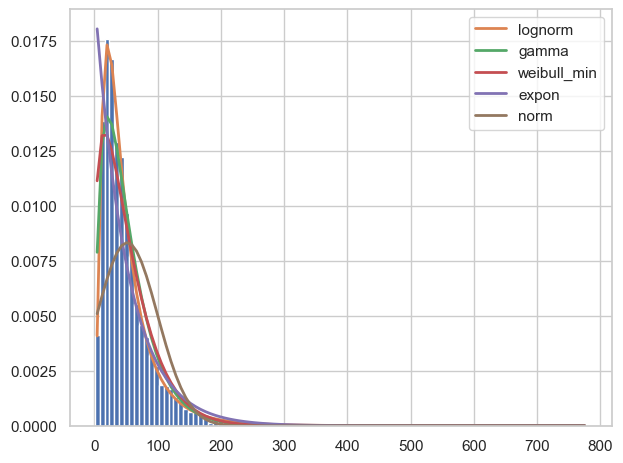

In [22]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helper: convertir el dict de parámetros de Fitter a tupla (shapes..., loc, scale)
def _args_from_params(dist_obj, params_dict):
    shape_names = []
    if getattr(dist_obj, "shapes", None):
        shape_names = [s.strip() for s in dist_obj.shapes.split(",")]
    args = [params_dict[s] for s in shape_names if s in params_dict]
    args += [params_dict.get('loc', 0.0), params_dict.get('scale', 1.0)]
    return tuple(args)

def _best_from_fitter(fit_obj):
    best = fit_obj.get_best(method='sumsquare_error')  # {name: params_dict}
    name, params = next(iter(best.items()))
    return name, params

# Tomar el “mejor ajuste” de TS
best_ts_name, best_ts_params = None, None
try:
    best_ts_name, best_ts_params = _best_from_fitter(f_ts)
except Exception as e:
    print("No hay ajuste TS en f_ts:", e)

# Tomar el “mejor ajuste” de LLIN
best_llin_name, best_llin_params = None, None
try:
    best_llin_name, best_llin_params = _best_from_fitter(f_llin)
except Exception as e:
    print("No hay ajuste LLIN en f_llin:", e)

# Re-samplear y re-ajustar para cada variable
np.random.seed(123)

def verificar(nombre_var, best_name, best_params, n=4000):
    if best_name is None or best_params is None:
        print(f"{nombre_var}: sin mejor FDP previa; no se verifica.")
        return None
    dist = getattr(stats, best_name)
    args = _args_from_params(dist, best_params)
    sint = dist.rvs(*args, size=n)
    sint = sint[np.isfinite(sint)]
    # Ajustar con Fitter usando las mismas distribuciones candidatas que antes
    DISTROS = ['expon','gamma','lognorm','norm','weibull_min']
    v = Fitter(sint, distributions=DISTROS)
    v.fit()
    print(f"\nVerificación {nombre_var}: muestreamos de {best_name} y re-ajustamos")
    print("Top (sumsquare_error):", v.get_best(method='sumsquare_error'))
    v.summary(5)
    plt.tight_layout()
    plt.gcf().savefig(f"outputs/verificacion_{nombre_var.lower().replace(' ','_')}.png", dpi=150)
    plt.show()
    return v

verif_ts   = verificar("TS (entre mints)", best_ts_name, best_ts_params)
verif_llin = verificar("LLIN (entre compras)", best_llin_name, best_llin_params)

# 7. Variables de Resultados


=== RESULTADOS ===
CTS (Cantidad total de tokenizaciones solicitadas): 359
PTB (Porcentaje de tokens burneados): 2.79% (burn=10, emitidos=359)
PSC (Promedio de saldo compradores): 1920.32
CTF (Cantidad de transferencias fallidas): 16


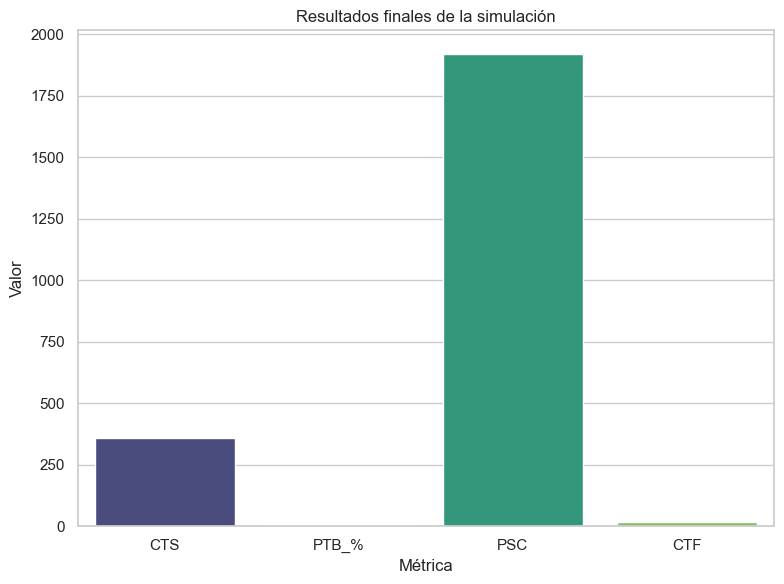

In [23]:
import os
os.makedirs("outputs", exist_ok=True)

# Métricas finales
CTS_final = int(CTS)
PTB_final_pct = (tokens_burneados / tokens_emitidos * 100.0) if tokens_emitidos > 0 else 0.0
PSC_final = float(np.mean(saldos_compradores)) if len(saldos_compradores) > 0 else 0.0
CTF_final = int(CTF)

# Tabla de métricas y export
res_df = pd.DataFrame([
    {"metrica": "CTS",   "valor": CTS_final},
    {"metrica": "PTB_%", "valor": PTB_final_pct},
    {"metrica": "PSC",   "valor": PSC_final},
    {"metrica": "CTF",   "valor": CTF_final},
])
res_df.to_csv("outputs/metricas.csv", index=False)

# (Opcional recomendado) Exportar conteo de eventos
evt_counts = df_eventos["evento"].value_counts().rename_axis("evento").reset_index(name="frecuencia")
evt_counts.to_csv("outputs/conteo_eventos.csv", index=False)

# Prints formateados
print("\n=== RESULTADOS ===")
print(f"CTS (Cantidad total de tokenizaciones solicitadas): {CTS_final}")
print(f"PTB (Porcentaje de tokens burneados): {PTB_final_pct:.2f}% "
      f"(burn={tokens_burneados}, emitidos={tokens_emitidos})")
print(f"PSC (Promedio de saldo compradores): {PSC_final:.2f}")
print(f"CTF (Cantidad de transferencias fallidas): {CTF_final}")

# Gráfico de barras (seaborn con hue para evitar FutureWarning)
plt.figure(figsize=(8,6))
sns.barplot(
    data=res_df,
    x="metrica", y="valor",
    hue="metrica", palette="viridis",
    dodge=False, legend=False
)
plt.xlabel("Métrica")
plt.ylabel("Valor")
plt.title("Resultados finales de la simulación")
plt.tight_layout()
plt.savefig("outputs/metricas_bar.png", dpi=150)
plt.show()

# 8. Visualizaciones de Resultados

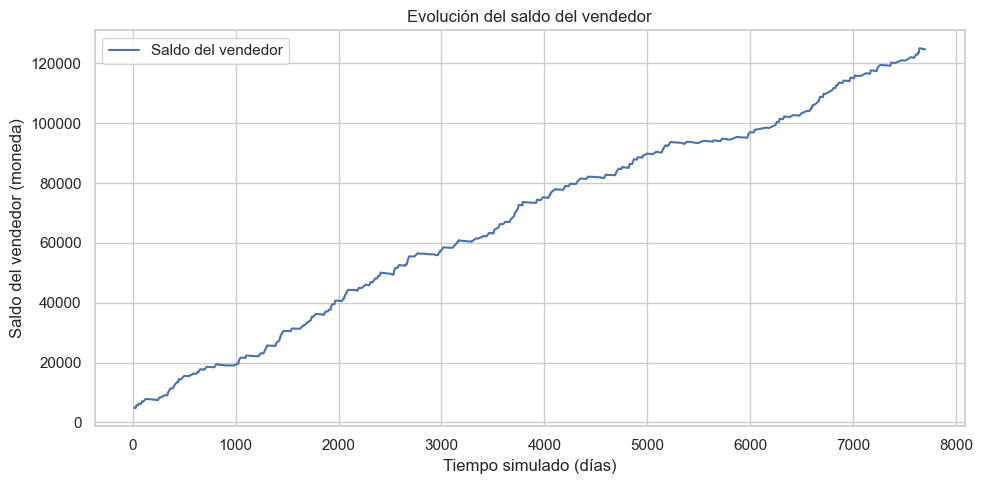

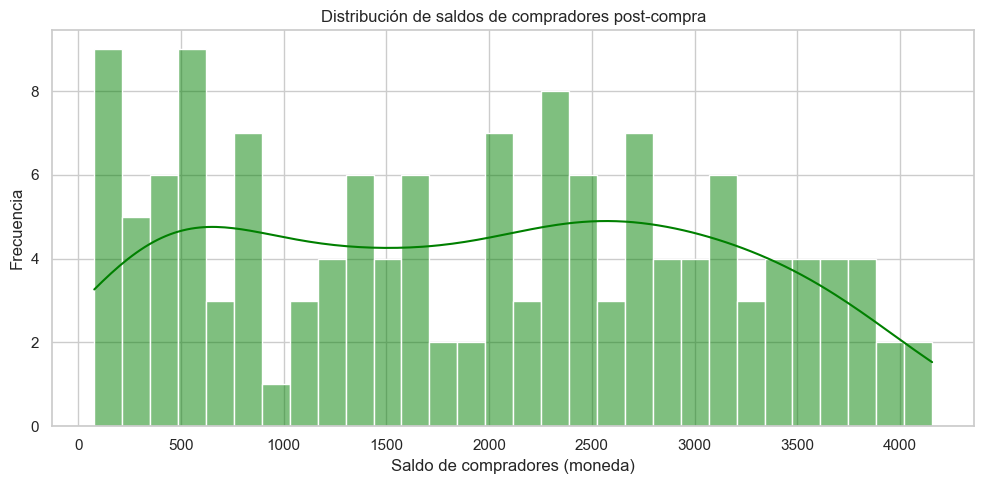

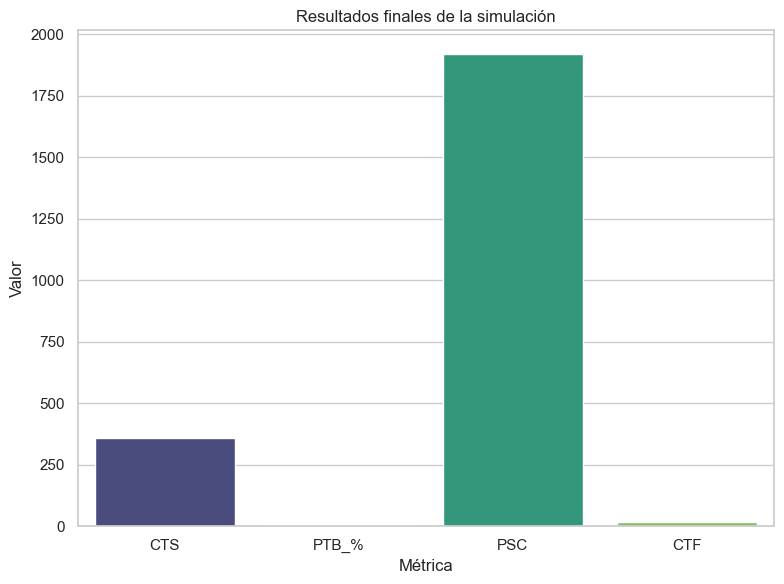

In [24]:
import os
os.makedirs("outputs", exist_ok=True)

# 6.1 Evolución del saldo del vendedor
plt.figure(figsize=(10,5))
sns.lineplot(data=df_eventos, x="tiempo", y="saldo_vendedor", label="Saldo del vendedor")
plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
plt.ylabel("Saldo del vendedor (moneda)")
plt.title("Evolución del saldo del vendedor")
plt.tight_layout()
plt.savefig("outputs/saldo_vendedor_tiempo.png", dpi=150)
plt.show()

# 6.2 Distribución de saldos de compradores (solo si hubo compras)
if len(saldos_compradores) > 0:
    plt.figure(figsize=(10,5))
    sns.histplot(saldos_compradores, bins=30, kde=True, color="green")
    plt.xlabel("Saldo de compradores (moneda)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de saldos de compradores post-compra")
    plt.tight_layout()
    plt.savefig("outputs/dist_saldos_compradores.png", dpi=150)
    plt.show()
else:
    print("No hay compras exitosas, no se grafica la distribución de saldos de compradores.")

# 6.3 Resumen de métricas (barplot) – sin FutureWarning en seaborn
# Usar PTB como porcentaje si está disponible
PTB_plot = None
if "PTB_final_pct" in locals():
    PTB_plot = PTB_final_pct
elif "PTB_final" in locals():
    PTB_plot = PTB_final * 100.0
else:
    PTB_plot = 0.0

res_df = pd.DataFrame([
    {"metrica": "CTS",    "valor": int(CTS_final)},
    {"metrica": "PTB_%",  "valor": float(PTB_plot)},
    {"metrica": "PSC",    "valor": float(PSC_final)},
    {"metrica": "CTF",    "valor": int(CTF_final)},
])

plt.figure(figsize=(8,6))
sns.barplot(
    data=res_df,
    x="metrica", y="valor",
    hue="metrica", palette="viridis",
    dodge=False, legend=False
)
plt.xlabel("Métrica")
plt.ylabel("Valor")
plt.title("Resultados finales de la simulación")
plt.tight_layout()
plt.savefig("outputs/metricas_bar.png", dpi=150)
plt.show()

# 9. Tokens en circulación vs tiempo

⏱ Tiempo simulado: 15.62 → 7699.11 días
📏 Duración total: 7683.50 días
📊 Registros: 552
🔢 Tokens en circulación (final): 349
📁 CSV: outputs/tokens_circulacion.csv
📁 Resumen guardado en: outputs/resumen_tiempo.csv


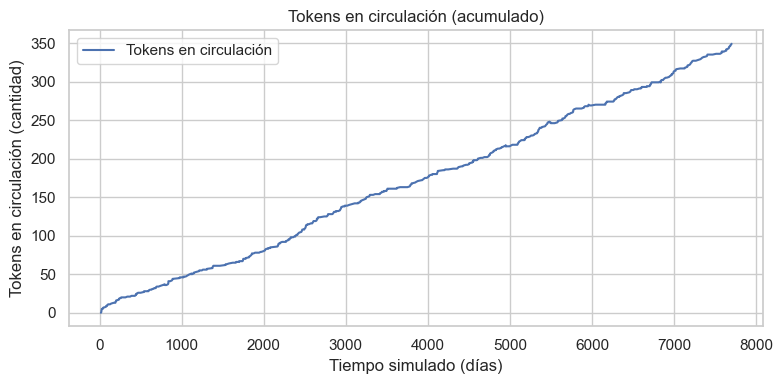

🖼️ PNG: outputs/tokens_circulacion.png


In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tokens_y_resumen(
    df_eventos: pd.DataFrame,
    csv_path: str = "outputs/tokens_circulacion.csv",
    png_path: str = "outputs/tokens_circulacion.png",
    resumen_path: str = "outputs/resumen_tiempo.csv",
    overwrite_csv: bool = True,
    make_plot: bool = True,
):
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # Validaciones mínimas
    if "evento" not in df_eventos.columns or "tiempo" not in df_eventos.columns:
        raise ValueError("df_eventos debe contener las columnas 'evento' y 'tiempo'.")

    # Normalización básica
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")

    # Solo 'mint' (+1) y 'burn_token' (-1) cambian el supply
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)

    tok = pd.DataFrame(
        {"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}
    ).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

    # Exportar CSV idempotente
    if overwrite_csv or not os.path.exists(csv_path):
        tok.to_csv(csv_path, index=False)

    # Resumen numérico
    if len(tok) > 0:
        t_min = float(tok["tiempo"].min())
        t_max = float(tok["tiempo"].max())
        duracion = t_max - t_min
        n_reg = int(len(tok))
        final_supply = int(tok["tokens_circulacion"].iloc[-1])
    else:
        t_min = t_max = duracion = 0.0
        n_reg = final_supply = 0

    print(f"⏱ Tiempo simulado: {t_min:.2f} → {t_max:.2f} {TIME_UNIT}")
    print(f"📏 Duración total: {duracion:.2f} {TIME_UNIT}")
    print(f"📊 Registros: {n_reg}")
    print(f"🔢 Tokens en circulación (final): {final_supply}")
    print(f"📁 CSV: {csv_path}")

    # Exportar resumen a CSV
    resumen_df = pd.DataFrame([{
        "tiempo_min": t_min,
        "tiempo_max": t_max,
        "duracion": duracion,
        "n_registros": n_reg,
        "tokens_final": final_supply,
        "unidad_tiempo": TIME_UNIT,
    }])
    resumen_df.to_csv(resumen_path, index=False)
    print(f"📁 Resumen guardado en: {resumen_path}")

    # Gráfico opcional
    if make_plot and len(tok) > 0:
        plt.figure(figsize=(8,4))
        plt.plot(tok["tiempo"], tok["tokens_circulacion"], label="Tokens en circulación")
        plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
        plt.ylabel("Tokens en circulación (cantidad)")
        plt.title("Tokens en circulación (acumulado)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(png_path, dpi=150)
        plt.show()
        print(f"🖼️ PNG: {png_path}")

    return tok, resumen_df

# ——— Uso ———
tok, resumen_tiempo = generar_tokens_y_resumen(
    df_eventos,
    csv_path="outputs/tokens_circulacion.csv",
    png_path="outputs/tokens_circulacion.png",
    resumen_path="outputs/resumen_tiempo.csv",
    overwrite_csv=True,    # False para NO reescribir el CSV existente
    make_plot=True         # False para no generar el PNG
)

# 10. Conclusiones

In [26]:
import os
import numpy as np
import pandas as pd
from textwrap import dedent

os.makedirs("outputs", exist_ok=True)

# ---- 1) Insumos: df_eventos, métricas, supply ----
# Métricas básicas (si no existen, las reconstruye)
CTS_val = int(CTS) if "CTS" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_emitidos_val = int(tokens_emitidos) if "tokens_emitidos" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_burneados_val = int(tokens_burneados) if "tokens_burneados" in locals() else int((df_eventos["evento"].str.lower()=="burn_token").sum())

if "PTB_final_pct" in locals():
    PTB_pct = float(PTB_final_pct)
else:
    PTB_pct = (tokens_burneados_val / tokens_emitidos_val * 100.0) if tokens_emitidos_val>0 else 0.0

PSC_val = float(PSC_final) if "PSC_final" in locals() else float(np.nan)
CTF_val = int(CTF) if "CTF" in locals() else int((df_eventos["evento"].str.contains("compra_fallida", case=False, na=False)).sum())

# Supply vs tiempo
tok_path = "outputs/tokens_circulacion.csv"
if os.path.exists(tok_path):
    tok = pd.read_csv(tok_path)
else:
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)
    tok = pd.DataFrame({"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

t_min = float(tok["tiempo"].min()) if len(tok)>0 else 0.0
t_max = float(tok["tiempo"].max()) if len(tok)>0 else 0.0
duracion = t_max - t_min
final_supply = int(tok["tokens_circulacion"].iloc[-1]) if len(tok)>0 else 0

# Tendencia del supply al final (slope en el último 30%)
if len(tok) >= 5:
    tail = tok.tail(max(5, int(len(tok)*0.3)))
    try:
        m, b = np.polyfit(tail["tiempo"], tail["tokens_circulacion"], 1)
    except Exception:
        m = 0.0
    if m > 0.02: tendencia_supply = "creciente"
    elif m < -0.02: tendencia_supply = "decreciente"
    else: tendencia_supply = "estable"
else:
    tendencia_supply = "indefinida"

# ---- 2) Tasas, fallas y stock ----
compras_mask = df_eventos["evento"].str.contains("compra", case=False, na=False)
total_compras = int(compras_mask.sum())
exitosas = int((df_eventos["evento"].str.lower()=="compra_exitosa").sum())
tasa_exito = (exitosas/total_compras*100.0) if total_compras>0 else np.nan

fall_fondos = int((df_eventos["evento"].str.lower()=="compra_fallida_fondos").sum())
fall_sintok = int((df_eventos["evento"].str.lower()=="compra_fallida_sin_tokens").sum())

# Stock sin vender al cierre: mint - burn - vendidas
mint_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "token"].dropna())
burn_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="burn_token", "token"].dropna())
sold_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="compra_exitosa", "token"].dropna())
stock_sin_vender = max(0, len(mint_ids - burn_ids - sold_ids))

# ---- 3) Intervalos TS / LLIN y “mejor FDP” si existiera ----
ts_series = (
    df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "tiempo"]
    .diff().dropna()
)
llin_series = (
    df_eventos.loc[df_eventos["evento"].str.contains("compra", case=False, na=False), "tiempo"]
    .diff().dropna()
)
ts_mean = float(ts_series.mean()) if len(ts_series)>0 else np.nan
llin_mean = float(llin_series.mean()) if len(llin_series)>0 else np.nan

def _best_name_from_fitter(fit_obj):
    try:
        best = fit_obj.get_best(method='sumsquare_error')
        return list(best.keys())[0]
    except:
        return None

best_ts_name = _best_name_from_fitter(f_ts) if "f_ts" in locals() else None
best_llin_name = _best_name_from_fitter(f_llin) if "f_llin" in locals() else None

if (best_ts_name is None or best_llin_name is None) and os.path.exists("outputs/ajustes_fdp.csv"):
    try:
        aj = pd.read_csv("outputs/ajustes_fdp.csv")
        if best_ts_name is None:
            row = aj.loc[aj["variable"].str.contains("TS", na=False)]
            if not row.empty: best_ts_name = str(row.iloc[0]["mejor_dist"])
        if best_llin_name is None:
            row = aj.loc[aj["variable"].str.contains("LLIN", na=False)]
            if not row.empty: best_llin_name = str(row.iloc[0]["mejor_dist"])
    except Exception:
        pass

# ---- 4) Recomendaciones automáticas (simples) ----
recs = []

# Oferta vs demanda
if not np.isnan(ts_mean) and not np.isnan(llin_mean):
    if ts_mean > llin_mean:
        recs.append("La tokenización (TS) es más lenta que las llegadas (LLIN): podés **acelerar TS** (mayor emisión) o **aumentar `partes_de_prop`** para reducir faltantes.")
    else:
        recs.append("La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.")

# Motivo principal de fallas
if fall_sintok > fall_fondos:
    recs.append("Las fallas por **falta de tokens** dominan: aumentar frecuencia de `mint` o **reducir `burn`** puede ayudar.")
elif fall_fondos > fall_sintok:
    recs.append("Las fallas por **fondos insuficientes** dominan: considerá **bajar `VALOR_TOKEN_MEDIA`** o modificar la distribución de saldos de compradores.")
else:
    if total_compras>0:
        recs.append("Las fallas se reparten parejo entre fondos y disponibilidad; podés actuar en ambos frentes: oferta y pricing.")

# PTB alto
if PTB_pct >= 20:
    recs.append("**PTB** elevado: revisar criterios de `burn_token` (P_BURN) para no erosionar el supply.")
elif PTB_pct <= 1 and tendencia_supply=="creciente":
    recs.append("**PTB** muy bajo y supply creciente: OK si es deseado; de lo contrario, introducir `burn` para controlar el circulante.")

# ---- 5) Componer conclusiones (Markdown) ----
ts_line   = f"- Tokenización (TS): media ≈ {ts_mean:.2f} {TIME_UNIT}" if not np.isnan(ts_mean) else "- Tokenización (TS): sin datos suficientes"
ts_line  += f"{' — mejor FDP: '+best_ts_name if best_ts_name else ''}"

llin_line = f"- Llegadas (LLIN): media ≈ {llin_mean:.2f} {TIME_UNIT}" if not np.isnan(llin_mean) else "- Llegadas (LLIN): sin datos suficientes"
llin_line+= f"{' — mejor FDP: '+best_llin_name if best_llin_name else ''}"

tasa_line = f"- Compras: {exitosas}/{total_compras} exitosas (**{tasa_exito:.1f}%**)" if total_compras>0 else "- Compras: sin eventos registrados"

conclusiones_md = dedent(f"""
## 10) Conclusiones

**Horizonte & Supply**
- Horizonte simulado: {duracion:.2f} {TIME_UNIT} (de {t_min:.2f} a {t_max:.2f}).
- Supply en circulación al cierre: **{final_supply}** tokens — tendencia **{tendencia_supply}**.
- PTB (burn): **{PTB_pct:.2f}%** ({tokens_burneados_val}/{tokens_emitidos_val}).
- Stock sin vender al cierre: **{stock_sin_vender}** tokens.

**Ritmos del sistema**
{ts_line}
{llin_line}

**Demanda & Éxito de compras**
{tasa_line}
- Fallidas por fondos: {fall_fondos}
- Fallidas por falta de tokens: {fall_sintok}

**Recomendaciones rápidas**
- """ + "\n- ".join(recs) + """
""").strip()

print(conclusiones_md)

with open("outputs/conclusiones.md", "w", encoding="utf-8") as f:
    f.write(conclusiones_md + "\n")

print("📁 Conclusiones guardadas en: outputs/conclusiones.md")

## 10) Conclusiones

**Horizonte & Supply**
- Horizonte simulado: 7683.50 días (de 15.62 a 7699.11).
- Supply en circulación al cierre: **349** tokens — tendencia **creciente**.
- PTB (burn): **2.79%** (10/359).
- Stock sin vender al cierre: **211** tokens.

**Ritmos del sistema**
- Tokenización (TS): media ≈ 21.45 días — mejor FDP: gamma
- Llegadas (LLIN): media ≈ 49.85 días — mejor FDP: lognorm

**Demanda & Éxito de compras**
- Compras: 138/154 exitosas (**89.6%**)
- Fallidas por fondos: 15
- Fallidas por falta de tokens: 1

**Recomendaciones rápidas**
- La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.
- Las fallas por **fondos insuficientes** dominan: considerá **bajar `VALOR_TOKEN_MEDIA`** o modificar la distribución de saldos de compradores.
📁 Conclusiones guardadas en: outputs/conclusiones.md
